In [2]:
## Clustering
from sklearn.decomposition import PCA
from scipy.linalg import norm
from scipy.linalg import eigh
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk 
import plotly_express as px

In [3]:
# Importing Data
path = '/Users/kritchanwong/Downloads/Plato-project-5001-main'
TFIDF = pd.read_csv(path + '/data_out/' +'tf_idf_plato.csv')
LIB = pd.read_csv(path + '/data_out/' + 'lib_plato.csv')
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']

<Figure size 432x288 with 0 Axes>

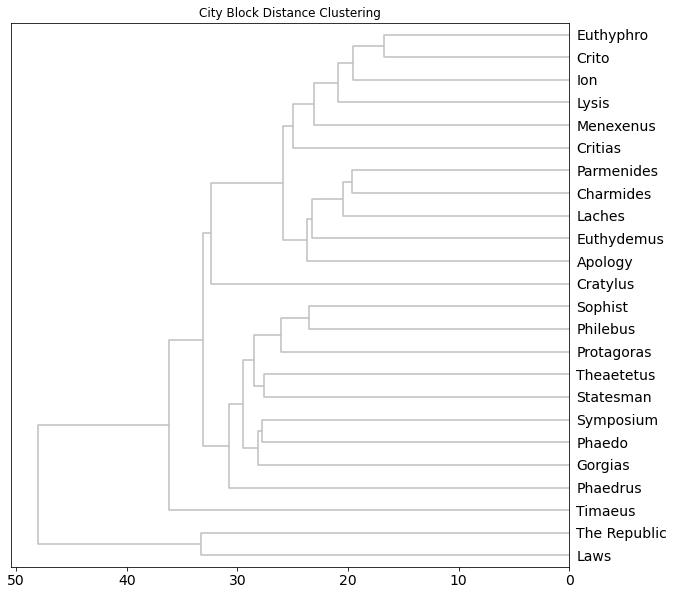

<Figure size 432x288 with 0 Axes>

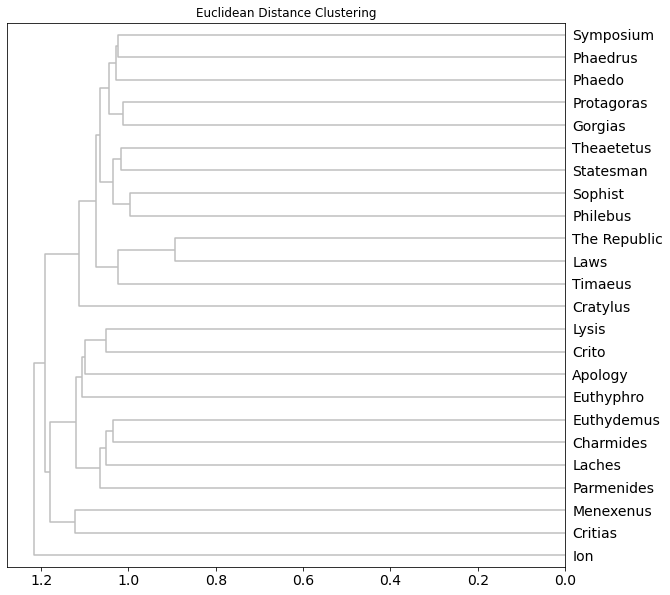

<Figure size 432x288 with 0 Axes>

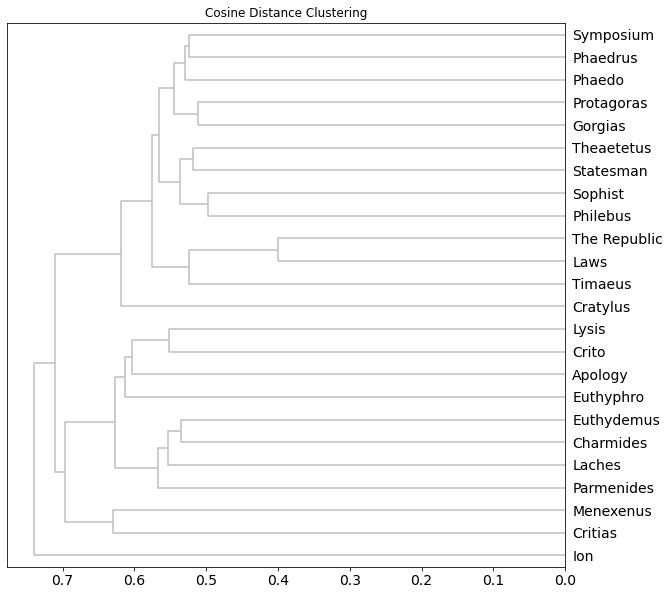

<Figure size 432x288 with 0 Axes>

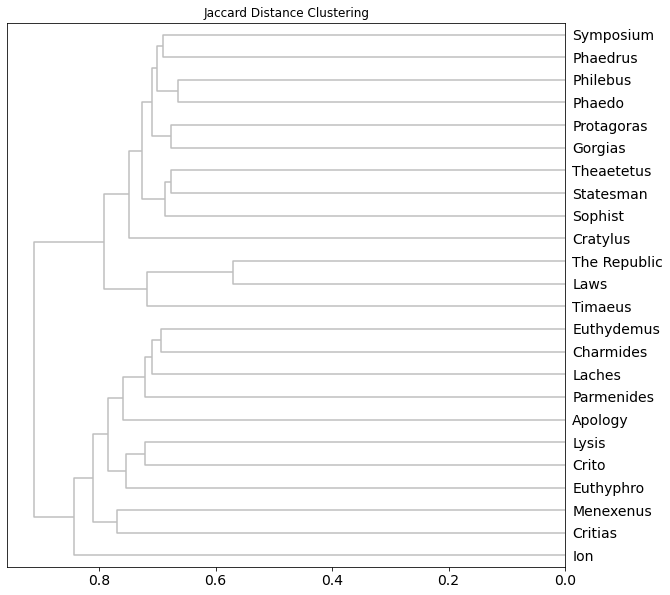

In [4]:
###Clustering
#Making Pairs
TFIDF = TFIDF.groupby(OHCO[:1]).mean() #Grouping by Book
DOC = pd.DataFrame(dict(book_id=TFIDF.index)) #Creating DOC
DOC.index.name = 'doc_id' 
L0 = TFIDF.astype('bool').astype('int') # Binary (Pseudo L)
L1 = TFIDF.apply(lambda x: x / x.sum(), 1) # Probabilistic
L2 = TFIDF.apply(lambda x: x / norm(x), 1) # Pythagorean
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([DOC.index.tolist(), DOC.index.tolist()])).reset_index() #Creating Pairs
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])

#Calculating distance, similarity and divergence
PAIRS['cityblock'] = pdist(TFIDF, 'cityblock')
PAIRS['euclidean'] = pdist(TFIDF, 'euclidean')
PAIRS['cosine'] = pdist(TFIDF, 'cosine')
PAIRS['jaccard'] = pdist(L0, 'jaccard')
SAMPLE = PAIRS


def hca(sims, title, linkage_method='complete', color_thresh=.1, figsize=(10, 10)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = DOC.book_id.values
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.title(title)

hca(PAIRS.cityblock, 'City Block Distance Clustering')
hca(PAIRS.euclidean, 'Euclidean Distance Clustering')
hca(PAIRS.cosine, 'Cosine Distance Clustering')
hca(PAIRS.jaccard, 'Jaccard Distance Clustering')


In [5]:
### PCA
#Preparing TFIDF
TFIDF = TFIDF - TFIDF.mean() #Normalising
COV = TFIDF.T.dot(TFIDF) / (TFIDF.shape[0] - 1) #Covariance Matrix

#Eigenvectorisaiton and Decomposing
eig_vals, eig_vecs = eigh(COV)
EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
EIG_VAL.index.name = 'term_str'
EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)
EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)
COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(10).reset_index(drop=True)
COMPS.index.name = 'comp_id'
COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]
COMPS.index.name = 'pc_id'

#Find Loadings
LOADINGS = COMPS[COV.index].T
LOADINGS.index.name = 'term_str'
LOADINGS.head()
top_terms = {}
for i in [0, 1]:
    for j in [0, 1]:
      top_terms[f"{i}_{j}"] = ' '.join(LOADINGS.sort_values(f'PC{i}', ascending=bool(j)).head(10).index.to_list())

#Visualisation
DCM = TFIDF.dot(COMPS[COV.index].T)
DCM = DCM.merge(LIB, on='book_id')
def vis_pcs(M, a, b, label='author', hover_name='LIB', symbol=None, size=None):
    fig = px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)
    fig.show()

vis_pcs(DCM.reset_index(), 0, 1,label='Period',hover_name='book_id')
vis_pcs(DCM.reset_index(), 0, 1,label='book_id',hover_name='Period')